<a href="https://colab.research.google.com/github/sangyunpark99/Vanilla-GAN/blob/main/Vanila_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla Generative Adversarial Networks

## Imports

In [5]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Google Drive Connect

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Settings and Dataset

In [6]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # gpu이용가능시 gpu, 아닐시엔 cpu 할당

# Hyperparameters
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
num_epochs = 100
batch_size = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x


train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True) # 학습용 데이터 셋 로드

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor()) # 테스트용 데이터 셋 로드


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True) 

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [7]:
class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential( # generator
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5), # 과대적합 방지
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential( # discriminator
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5), # 과대적합 방지
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = self.discriminator(img)
        print(f"pred.view(-1) : {pred.view(-1)}")
        return pred.view(-1) # 판별 결과 텐서를 1차원 텐서로 변환 | -1은 나머지 차원을 자동으로 계산하여 텐서를 1차원으로 만듦

In [8]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [9]:
model

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Tanh()
  )
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

## Training

In [ ]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader): # enumrate : 인덱스와 값을 동시에 반환

        
        
        features = (features - 0.5)*2. # normalize화 시켜주기
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device) # targets : 정답 label

        valid = torch.ones(targets.size(0)).float().to(device) # 진짜 이미지임을 나타냄
        fake = torch.zeros(targets.size(0)).float().to(device) # 가짜 이미지임을 나타냄
        

        ### FORWARD AND BACK PROP
        
        
        # --------------------------
        # Generator 학습
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        gener_loss = F.binary_cross_entropy(discr_pred, valid) # 생성자의 손실함수를 계산
        
        optim_gener.zero_grad() # 이전 스텝의 기울기가 현재 스텝에 누적되지 않게 함
        gener_loss.backward() # 역전파를 수행하여, 생성자 가중치 기울기 계산
        optim_gener.step() # 계산된 기울기를 사용해 생성자의 가중치를 업데이트
        
        # --------------------------
        # Discriminator 학습
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE)) # 실제 이미지를 입력받아 이미지가 진짜인지 가짜인지 판별
        real_loss = F.binary_cross_entropy(discr_pred_real, valid) # 실제 이미지를 받았을때 얼마나 잘 분별하는지 측정하는 손실함수 계산 | valid : 진짜 이미지에 대한 정답 레이블
        
        discr_pred_fake = model.discriminator_forward(generated_features.detach()) # 가짜 이미지를 판별자에 입력하여 판별 결과 얻기 | detach : 생성자와 판별자의 그래디언트가 연결되지 않도록 가짜 이미지를 별도의 텐서로 분리
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake) # 판별자가 가짜 이미지를 받았을 때 얼마나 잘 분류하는지 측정하는 손실 함수 | fake : 가짜 이미지에 대한 정답 레이블
        
        discr_loss = 0.5*(real_loss + fake_loss) # 판별자의 전체 손실 : 실제 이미지에 대한 손실과 가짜 이미지에 대한 손실의 평균

        optim_discr.zero_grad() # 이전 스텝에 계산된 그래디언트를 초기화
        discr_loss.backward() # 판별자의 손실에 대한 그래디언트 역전파 수행
        optim_discr.step() # 계산된 그래디언트를 사용하여 판별자의 매개변수 업데이트
        
        discr_costs.append(discr_loss.item()) # 판별자의 손실을 기록
        gener_costs.append(gener_loss.item()) # 생성자의 손실을 기록
        
        
        ### LOGGING
        if not batch_idx % 100: # batch_index가 100의 배수일 때마다 아래 코드를 실행
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

## Evaluation

In [12]:
import matplotlib.pyplot as plt

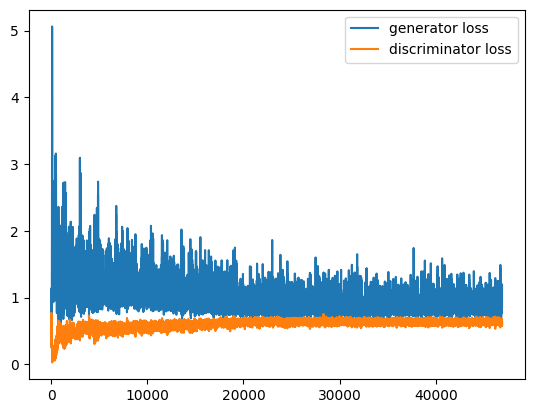

In [13]:
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.show()

## Result

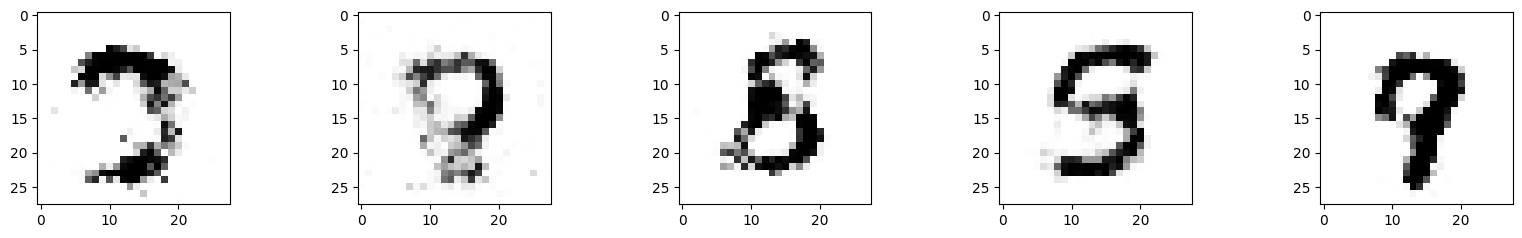

In [28]:
## 결과 출력!


model.eval() # 모델을 평가 모드로 전환
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device) # 무작위 5개 벡터 생성
generated_features = model.generator_forward(z) # 새로운 이미지 생성
imgs = generated_features.view(-1, 28, 28) # 생성된 이미지를 적절한 형태로 변환 가로 28px, 세로 28px

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5)) # 1행 5열 서브플롯을 생성하고, 가로 20인치, 세로 2.5인치


for i, ax in enumerate(axes): # 생성된 이미지를 순회하며 각 이미지를 서브플롯에 출력
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary') # 생성된 이미지를 CPU로 이동하고, 그래디언트 추적을 중단하기 위해 detach()함수를 호출, imshow()로 이미지 출력, colormap은 2진(흑백)으로 설정